<h1>Phase 4 Final Project Submission</h1>

<h3>Student Name: Jason Lombino</h3>
<hr>

<h1>Business Problem</h1>

<h1>Import Libraries</h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from skimage.segmentation import mark_boundaries
from lime import lime_image
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import applications
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

<h1>Data</h1>

The following <a href=https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia>dataset</a> was provided for modeling. It contains thousands of chest xrays from children with and without pneumonia. The data is pre-separated into train, test, and validation folders. However, the provided validation dataset was too small to be of any use. Prior to performing any modeling <b>I manually moved 20% of the training data into the validation folder</b>. The remaining images in the training folder were used to train models, and the test data was used as provided. The following code loads the image data.

In [2]:
# Data should be in three folders (train, test, and val)
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
val_path = 'chest_xray/val'

In [3]:
# Data generator with some preprocessing steps for training data
train_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=45,
    zoom_range=0.3
)

train_ds = train_generator.flow_from_directory(
    train_path,
    target_size=(256,256),
    class_mode='binary',
)

# Class sizes for pie chart
train_norm = len(os.listdir(train_path + '/NORMAL'))
train_sick = len(os.listdir(train_path + '/PNEUMONIA'))

Found 4175 images belonging to 2 classes.


In [4]:
# Data generator without proprocessing steps for validation data
val_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Shuffle is not needed for test and validation data
val_ds = val_generator.flow_from_directory(
    val_path,
    target_size=(256,256),
    class_mode='binary',
    shuffle=False
)

# Class sizes for pie chart
val_norm = len(os.listdir(val_path + '/NORMAL'))
val_sick = len(os.listdir(val_path + '/PNEUMONIA'))

Found 1057 images belonging to 2 classes.


In [5]:
# Data generator without preprocessing steps for test data
test_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Shuffle is not needed for test and validation data
test_ds = test_generator.flow_from_directory(
    test_path,
    target_size=(256,256),
    class_mode='binary',
    shuffle=False
)

# Class sizes for pie chart
test_norm = len(os.listdir(test_path + '/NORMAL'))
test_sick = len(os.listdir(test_path + '/PNEUMONIA'))

Found 624 images belonging to 2 classes.


<h1>Data Visualizations</h1>

There is approximately a 3:1 class imbalance in the train and validation datasets, and approximately a 2:1 class imbalance in the test dataset.

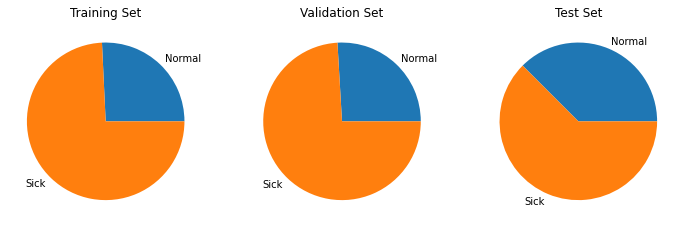

In [6]:
data_fig, data_ax = plt.subplots(1,3,figsize=(12,4))

# Training class sizes
data_ax[0].pie([train_norm,train_sick],labels=['Normal','Sick']);
data_ax[0].set_title('Training Set');

# Validation class sizes
data_ax[1].pie([val_norm,val_sick],labels=['Normal','Sick']);
data_ax[1].set_title('Validation Set');

# Test class sizes
data_ax[2].pie([test_norm,test_sick],labels=['Normal','Sick']);
data_ax[2].set_title('Test Set');

data_fig.set_facecolor('#FFFFFF')

Looking at some examples of normal xrays.

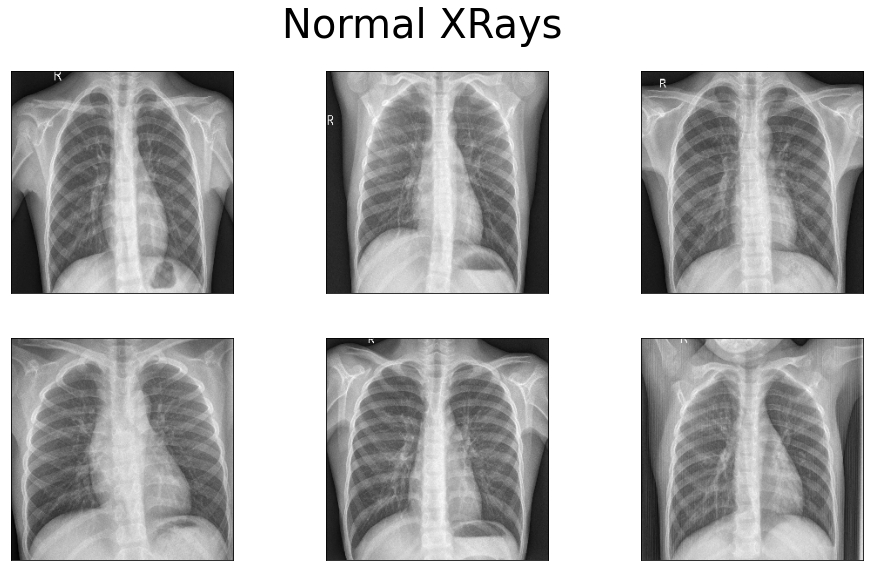

In [7]:
normal_images = []

# Pull 6 normal images from the test set
# Test set is ordered so normal images are at the beginning
for image in test_ds[0][0][:6]:
    normal_images.append(image)

normal_fig,normal_ax = plt.subplots(2,3,figsize=(16,9))

# Plot the 6 normal images pulled from the test set
for idx,image in enumerate(normal_images[:6]):
        active_axis = normal_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
normal_fig.set_facecolor('#FFFFFF')
normal_fig.suptitle('Normal XRays', fontsize=40);

Looking at some examples of Pneumonia xrays.

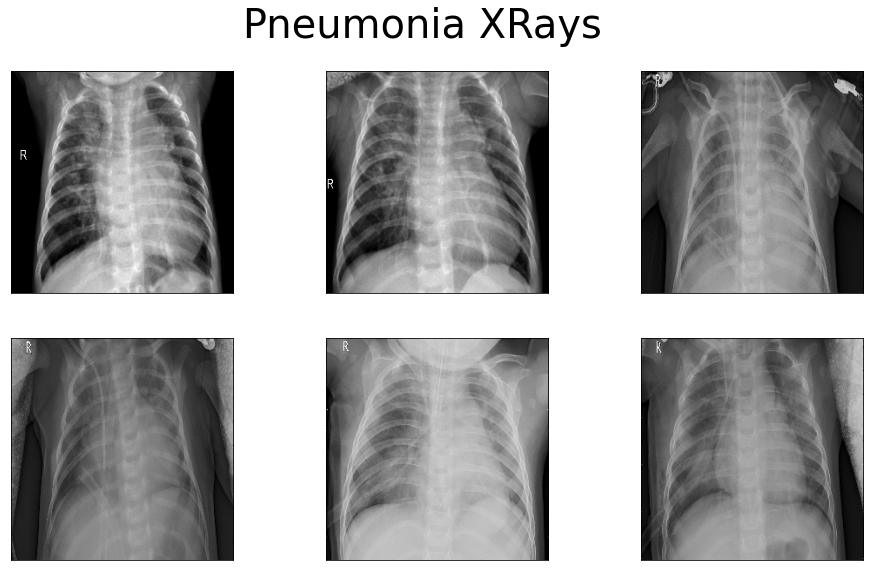

In [8]:
sick_images = []

# Pull 6 pneumonia images from the test set
# Test set is ordered so sick images are at the end
for image in test_ds[len(test_ds)-1][0][:6]:
    sick_images.append(image)

sick_fig,sick_ax = plt.subplots(2,3,figsize=(16,9))

# Plot the 6 pneumonia images pulled from the test set
for idx,image in enumerate(sick_images[:6]):
        active_axis = sick_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
sick_fig.set_facecolor('#FFFFFF')
sick_fig.suptitle('Pneumonia XRays', fontsize=40);

The training set is preprocessed before it is used to train the model. They can be horizontally flipped, zoomed in or out up to 30%, or rotated up to 45 degrees in either direction.

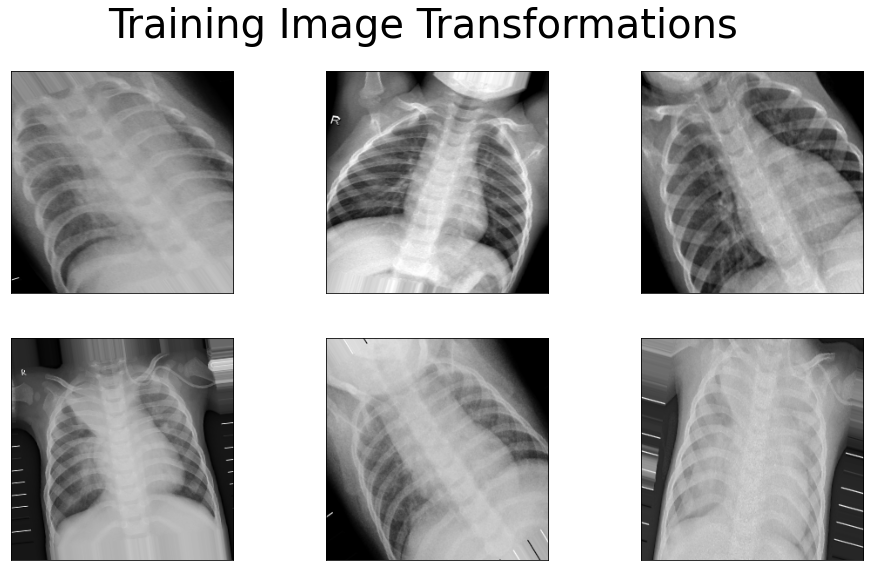

In [9]:
# Pull the first 6 images from the training set
train_prep = train_ds[0][0][:6]

train_fig,train_ax = plt.subplots(2,3,figsize=(16,9))

# Plot the 6 transformed images pulled from the training set
for idx,image in enumerate(train_prep[:6]):
        active_axis = train_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
train_fig.set_facecolor('#FFFFFF')
train_fig.suptitle('Training Image Transformations', fontsize=40);

<h1>Iterative Modeling</h1>

I made several models while trying to determine the best convolutional neural network (CNN) architecture and hyperparameters for classifying the xrays. The training and validation results for each of the models can be seen in the table below. Each model has a corresponding jupyter notebook located <a href=notebooks/>here</a>.

<h3><a href=notebooks/01_basic_model.ipynb>01</a> Basic CNN</h3>
I started with a very basic model that used a small neural network and did not preprocess images. This was used as a starting point for the rest of my models, but was not considered when selecting final models.

<h3><a href=notebooks/02_image_preprocessing.ipynb>02</a> Basic CNN Image Preprocessing</h3>
This model attempts to improve on the basic CNN by adding image preprocessing to reduce overfitting. 

<h3><a href=notebooks/03_larger_network.ipynb>03</a> Larger CNN</h3>
This model attempts to improve on on the basic CNN by increasing the size of the neural network. Both the number of layers and the size of each layer is increased. 

<h3><a href=notebooks/04_tanh_activation.ipynb>04</a> Larger CNN tanh Activation</h3>
This model attempts to improve on the basic CNN by using a tanh activation function for each layer rather than relu. It performs much worse overall in testing and on validation data.

<h3><a href=notebooks/05_dropout.ipynb>05</a> Larger CNN Dropout</h3>
This model attempts to improve on the basic CNN by adding dropout layers to reduce overfitting.

<h3><a href=notebooks/06_larger_stride.ipynb>06</a> Larger CNN Larger Stride</h3>
This model attempts to improve on the basic CNN by increasing the stride of the filter in each convolutional layer.

<h3><a href=notebooks/07_double_conv.ipynb>07</a> Larger CNN Double Convolutional Layers</h3>
This model attempts to improve on the basic CNN by adding additional convolutional layers.

<h3><a href=notebooks/08_even_larger_network.ipynb>08</a> Even Larger CNN</h3>
This model attempts to improve on the basic CNN by adding additional convolutional and dense layers. Both the number of layers and the size of each layer is increased. 

<h3><a href=notebooks/09_transfer_xc.ipynb>09</a> Transfer Learning Xception</h3>
This model attempts to imrpove on the basic CNN by using the <a href=https://keras.io/api/applications/xception/>Xception</a> model as its convolutional base.

<h3><a href=notebooks/10_transfer_vgg.ipynb>10</a> Trnasfer Learning VGG16</h3>
This model attempts to imrpove on the basic CNN by using the <a href=https://keras.io/api/applications/vgg/>VGG16</a> model as its convolutional base.

<h3><a href=notebooks/11_vgg_decay.ipynb>11</a> Trnasfer Learning VGG16 Decaying Learning Rate</h3>
This model attempts to imrpove on the basic CNN by using the <a href=https://keras.io/api/applications/vgg/>VGG16</a> model as its convolutional base. It also decreases the learning rate each epoch.

<h1>Comparison of Models</h1>

| Model Name                                     | % Train Accuracy | % Val Accuracy | 
|------------------------------------------------|------------------|----------------|
| * Basic CNN                                    | 98.8             | 96.7           | 
| Basic CNN Image Preprocessing                  | 93.5             | 91.2           | 
| Larger CNN                                     | 93.5             | 94.0           | 
| Larger CNN tanh Activation                     | 74.3             | 74.1           | 
| Larger CNN Dropout                             | 93.3             | 94.0           | 
| Larger CNN Larger Stride                       | 95.3             | 93.4           | 
| Larger CNN Double Convolutional Layers         | 95.5             | 94.0           | 
| Even Larger CNN                                | 94.8             | 94.5           | 
| Transfer Learning Xception                     | 96.6             | 94.0           | 
| Transfer Learning VGG16                        | 95.0             | 95.7           | 
| Transfer Learning VGG16 Decaying Learning Rate | 94.7             | 94.2           |

<h1>Second Best Model - 08 Even Larger CNN</h1>

The second best performing model on validation data was 08 Even Larger CNN. The following code creates the model.

In [10]:
nt_model = models.Sequential()

# First convolutional block
nt_model.add(layers.Conv2D(32, (1, 1), activation='relu',padding='same',
                        input_shape=(256, 256, 3)))     
nt_model.add(layers.Conv2D(32, (1, 1), activation='relu',padding='same'))                
nt_model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional block
nt_model.add(layers.Conv2D(64, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(64, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional block
nt_model.add(layers.Conv2D(128, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(128, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

# Fourth convolutional block
nt_model.add(layers.Conv2D(256, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(256, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

# Densely connected block with dropout
nt_model.add(layers.Flatten())
nt_model.add(layers.Dense(512, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(512, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(256, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(128, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(64, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(32, activation='relu'))
nt_model.add(layers.Dense(1, activation='sigmoid'))

Using checkpoints to save the epoch that does best on the validation data.

In [11]:
# Checkpoint the model after each epoch
nt_checkpoint = callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='save_data/nt_model.hdf5',
    save_best_only=True,
    verbose=0
)

nt_callbacks = [nt_checkpoint]

# Metrics are Accuracy, Precision, and Recall
use_metrics = [metrics.BinaryAccuracy(),\
                metrics.Precision(),\
                metrics.Recall()]

In [12]:
# Compile the model with the Adam optimizer
nt_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=[use_metrics]
)

# Print overview of the model
print(nt_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      128       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      2112      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    

It may be necessary to change this cell to get the notebook to run on your computer. <b>If you do not have a working GPU change '/GPU:0' to /CPU:0'.</b> This cell fits the model and saves the results to history. It then loads the best epoch from the checkpoint.

In [13]:
# Fit the model and save the results to history
with tf.device('/GPU:0'):
    nt_history = nt_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        callbacks=nt_callbacks
    )

# Load the best model based on validation loss
nt_model.load_weights('save_data/nt_model.hdf5')

Epoch 1/5
131/131 [==============================] - 49s 332ms/step - loss: 0.5548 - binary_accuracy: 0.7332 - precision: 0.7430 - recall: 0.9794 - val_loss: 0.5276 - val_binary_accuracy: 0.7408 - val_precision: 0.7408 - val_recall: 1.0000
Epoch 2/5
131/131 [==============================] - 42s 321ms/step - loss: 0.3851 - binary_accuracy: 0.8125 - precision: 0.8315 - recall: 0.9374 - val_loss: 0.3432 - val_binary_accuracy: 0.8344 - val_precision: 0.9780 - val_recall: 0.7944
Epoch 3/5
131/131 [==============================] - 42s 322ms/step - loss: 0.3014 - binary_accuracy: 0.8766 - precision: 0.9118 - recall: 0.9232 - val_loss: 0.2233 - val_binary_accuracy: 0.9016 - val_precision: 0.9392 - val_recall: 0.9272
Epoch 4/5
131/131 [==============================] - 42s 321ms/step - loss: 0.2581 - binary_accuracy: 0.9008 - precision: 0.9296 - recall: 0.9374 - val_loss: 0.2217 - val_binary_accuracy: 0.9120 - val_precision: 0.9726 - val_recall: 0.9068
Epoch 5/5
131/131 [=====================

The following cell shows the training and validation accuracy and loss for each epoch. Accuracy should trend upwards and loss should trend downwards with more epochs. Validation accuracy will generally be lower than training accuracy, and validation loss will generally be higher than training loss.

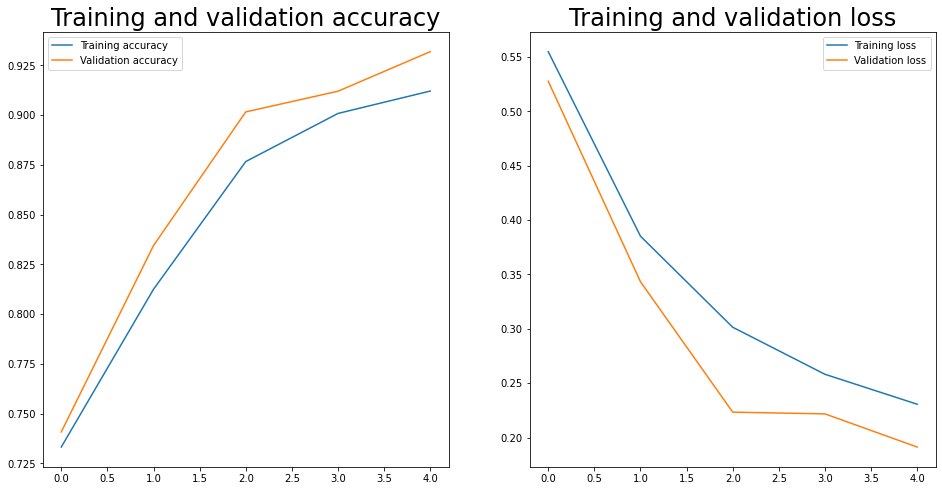

In [14]:
# Grab model results from history dict for plotting
nt_acc = nt_history.history['binary_accuracy']
nt_val_acc = nt_history.history['val_binary_accuracy']
nt_loss = nt_history.history['loss']
nt_val_loss = nt_history.history['val_loss']
nt_epochs = range(len(nt_acc))

# Plot train and val accuracy for each epoch
nt_fig,nt_ax = plt.subplots(1,2,figsize=(16,8))
nt_ax[0].plot(nt_epochs, nt_acc, label='Training accuracy');
nt_ax[0].plot(nt_epochs, nt_val_acc, label='Validation accuracy');
nt_ax[0].set_title('Training and validation accuracy',fontsize=24);
nt_ax[0].legend();

# Plot train and val loss for each epoch
nt_ax[1].plot(nt_epochs, nt_loss, label='Training loss');
nt_ax[1].plot(nt_epochs, nt_val_loss, label='Validation loss');
nt_ax[1].set_title('Training and validation loss',fontsize=24);
nt_ax[1].legend();

<h1>Model Results</h1>

In [15]:
# Evaluate the model on training set
nt_train_results = nt_model.evaluate(train_ds)

131/131 [==============================] - 39s 295ms/step - loss: 0.1970 - binary_accuracy: 0.9298 - precision: 0.9570 - recall: 0.9481


In [16]:
# Evaluate the model on validation set
nt_val_res = nt_model.evaluate(val_ds)

34/34 [==============================] - 3s 95ms/step - loss: 0.1912 - binary_accuracy: 0.9319 - precision: 0.9811 - recall: 0.9259


In [17]:
# Evaluate the model on test set
nt_test_res = nt_model.evaluate(test_ds)

20/20 [==============================] - 2s 81ms/step - loss: 0.3407 - binary_accuracy: 0.8766 - precision: 0.8631 - recall: 0.9538


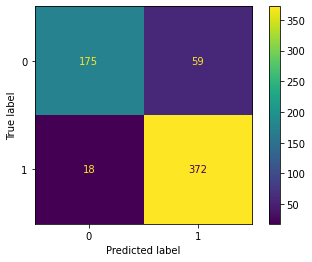

In [18]:
# Get predictions for test set and actual values
nt_test_predictions = np.round(nt_model.predict(test_ds),0)
test_actual = test_ds.labels

# Generate confusion matrix for test set
nt_c_matrix = confusion_matrix(test_actual,nt_test_predictions)
ConfusionMatrixDisplay(nt_c_matrix).plot()

<h1><a href=https://github.com/marcotcr/lime>Lime</a> Explanation of Results

In [19]:
explainer = lime_image.LimeImageExplainer()

A helper function to extract certain images from the test dataset. <b>For a given model</b> the function can be used to extract:
<ul><li>True Positive Examples
<li>True Negative Examples
<li>False Positive Examples
<li>False Negative Examples

In [20]:
def extract_selected(model,true,predicted):
    selected = []

    #Loop through each image in each batch of the test dataset
    for batch in range(len(test_ds)):
        for idx,image in enumerate(test_ds[batch][0]):

            # Stop when 6 images are selected and return them
            if len(selected) >= 6:
                return(selected)

            # Select image if true and predicted classes match what was specified    
            else:
                if np.round(model.predict(np.expand_dims(image,axis=0)),0) == predicted \
                    and test_ds[batch][1][idx] == true:
                    selected.append(image)

        # Stop when 6 images are selected and return them
        if len(selected) >= 6:
                return(selected)

    # Return all images if less than 6 were selected
    return(selected)

A helper function that uses lime to explain the selected images. It returns a formatted figure with the explanations.

In [21]:
def lime_explain(model,selected_images,title):
    fig,ax = plt.subplots(2,3,figsize=(12,6))

    # Loop through each of up to 6 provided image
    for idx, image in enumerate(selected_images):
        active_axis = ax[idx//3][idx%3]
        active_axis.set_xticks([])
        active_axis.set_yticks([])

        # Generate explanation for prediction using Lime image explainer
        explanation = explainer.explain_instance(
            image, model.predict, top_labels=1, hide_color=0, num_samples=1000)

        # Generate image mask for explanation    
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],\
             positive_only=False, num_features=5, hide_rest=False)

        # Show the image and explanation
        active_axis.imshow(mark_boundaries(temp, mask))
    fig.set_facecolor('#FFFFFF')
    fig.suptitle(title,fontsize=32);
    return(fig)

<h1>True Positives</h1>

Xrays that contain pneumonia that the model correctly identifies as containing pneumonia.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

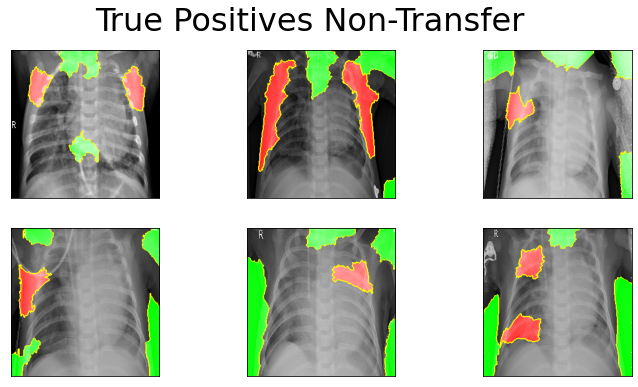

In [22]:
# Extract true positives from test set and explain with lime
nt_tp = extract_selected(nt_model,1,1)
nt_tp_expl = lime_explain(nt_model,nt_tp,"True Positives Non-Transfer")

<h1>True Negatives</h1>

Xrays that are normal that the model correctly identifies as normal.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

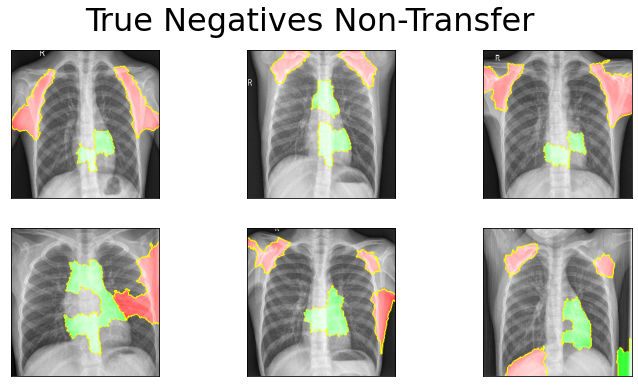

In [23]:
# Extract true negatives from test set and explain with lime
nt_tn = extract_selected(nt_model,0,0)
nt_tn_expl = lime_explain(nt_model,nt_tn,"True Negatives Non-Transfer")

<h1>Fasle Positives</h1>

Xrays that are normal that the model incorrectly identifies as having pneumonia.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

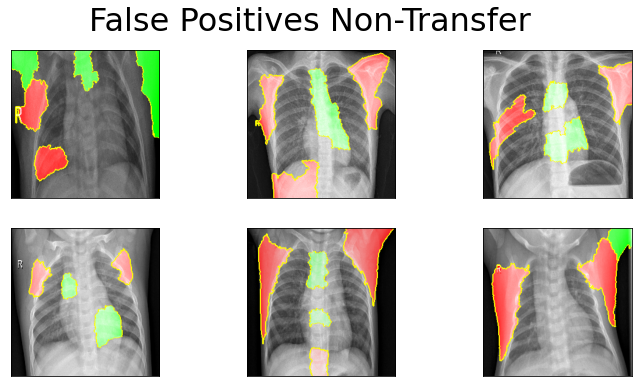

In [24]:
# Extract false positives from test set and explain with lime
nt_fp = extract_selected(nt_model,0,1)
nt_fp_expl = lime_explain(nt_model,nt_fp,"False Positives Non-Transfer")

<h1>False Negatives</h1>

Xrays that have pneumonia that the model incorrectly identifies as normal.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

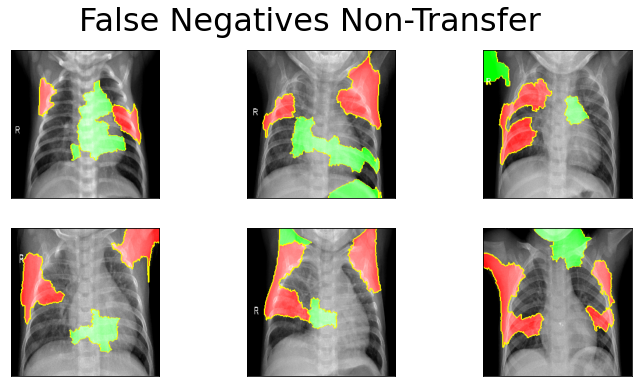

In [25]:
# Extract false negatives from test set and explain with lime
nt_fn = extract_selected(nt_model,1,0)
nt_fn_expl = lime_explain(nt_model,nt_fn,"False Negatives Non-Transfer")

<h1>Intermediate Activations</h1>

The following attempts to show what each of the intermediate layers of the model "sees".

In [26]:
# Print overview of the model
nt_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      128       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      2112      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    

The following cell returns the activation for each node in the network when a single image is passed through it.

In [27]:
# Collect outputs for the first 12 layers of model
nt_layer_outputs = [layer.output for layer in nt_model.layers[:12]]

activation_model = models.Model(
    inputs = nt_model.input,
    outputs = nt_layer_outputs
)

# Predict the first image in test dataset and save intermediate activations
nt_activations = activation_model.predict(np.expand_dims(test_ds[0][0][0],axis=0))

This figure shows the activation of each node in the first convolutional layer of the network.

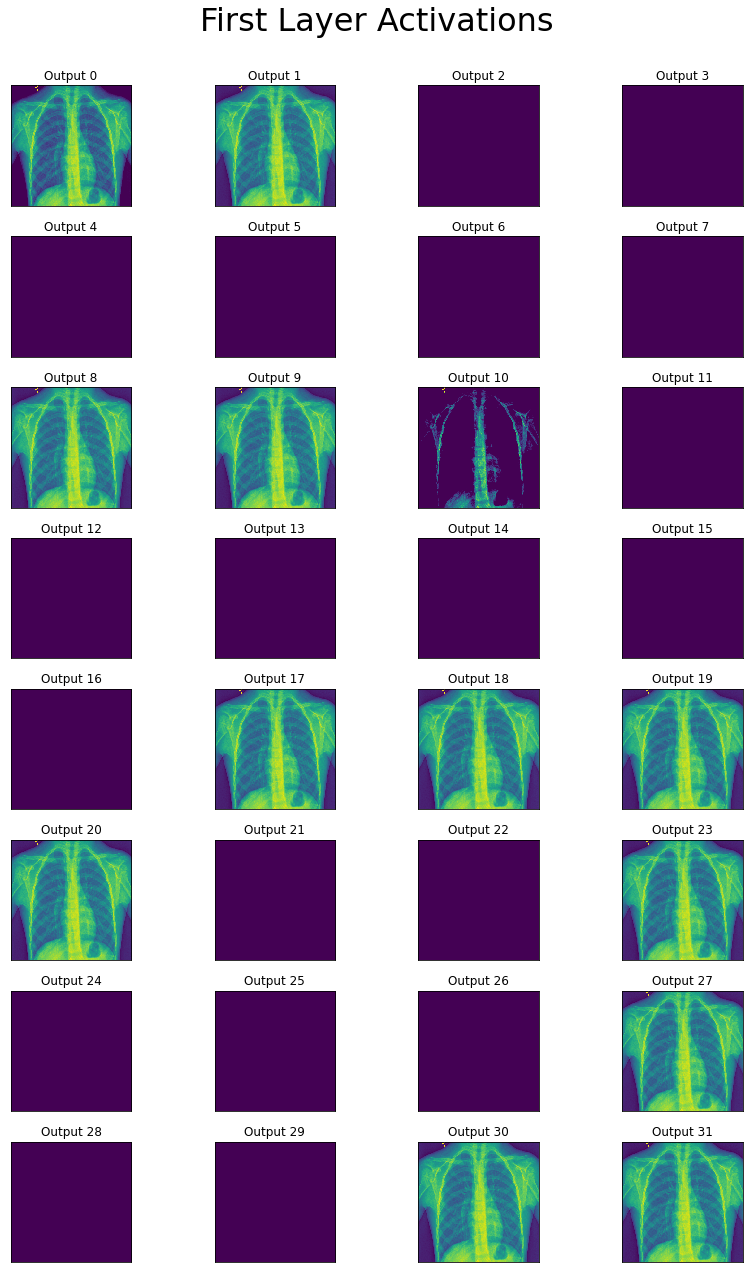

In [28]:
nt_l0_fig, nt_l0_ax = plt.subplots(8, 4, figsize=(12,18))

# Loop through each node in the first layer size 32
for idx in range(32):
    active_axis = nt_l0_ax[idx//4, idx%4]

    # Extract and show node's activation
    first_layer_activation = nt_activations[0]
    active_axis.matshow(first_layer_activation[0, :, :, idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    active_axis.set_title('Output ' + str(idx))
nt_l0_fig.set_facecolor('#FFFFFF')
nt_l0_fig.suptitle('First Layer Activations\n',fontsize=32);
nt_l0_fig.tight_layout()

This figure shows the activation of the first node in each convolutional and pooling layer of the network.

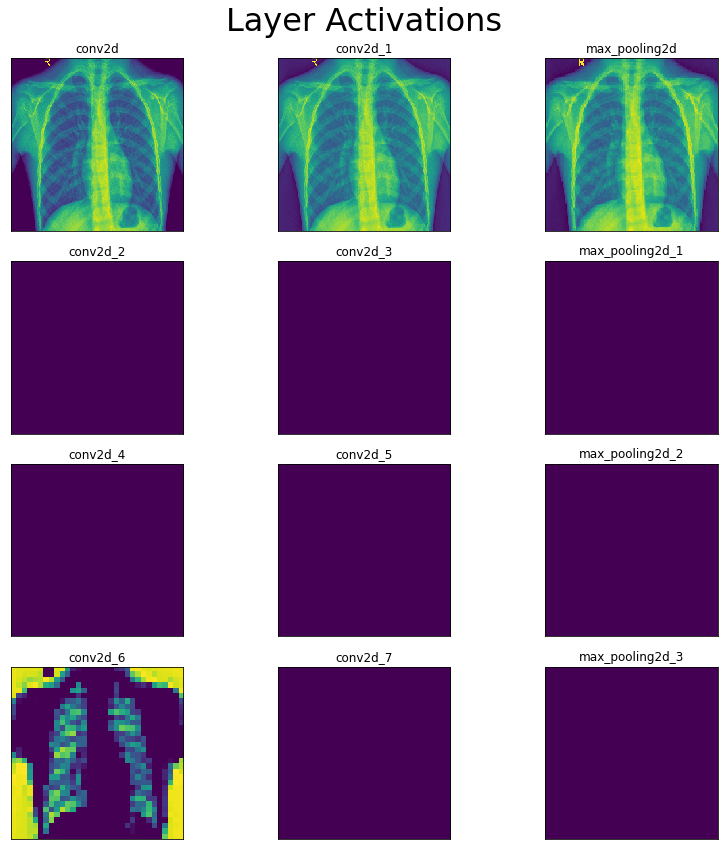

In [29]:
nt_act_fig,nt_act_ax = plt.subplots(4,3,figsize=(12,12))

# Get name for each of the first 12 layers
nt_layer_names = []
for layer in nt_model.layers[:12]:
    nt_layer_names.append(layer.name)

# Loop through each of the first 12 layers
for idx in range(12):
    active_axis = nt_act_ax[idx//3][idx%3]

    # Show the activation for the first node in that layer
    cur_layer = nt_activations[idx]
    active_axis.matshow(cur_layer[0,:,:,0])
    active_axis.set_title(nt_layer_names[idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
nt_act_fig.set_facecolor('#FFFFFF')
nt_act_fig.suptitle('Layer Activations',fontsize=32);
nt_act_fig.tight_layout()

<h1>Best Model - 10 Transfer Learning with VGG16</h1>

The best performing model on validation data was 10 Transfer Learning with VGG16. The following code creates the model and sets the VGG16 layers to be not trainable.

In [30]:
# Download and load VGG16 pre-trained model
vgg_base = applications.VGG16(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False
)

# Don't allow vgg16 weights to be changed
vgg_base.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [31]:
tx_model = models.Sequential()

# Add vgg16 base to transfer model
tx_model.add(vgg_base)     

# Densely connected block without dropout
tx_model.add(layers.Flatten())
tx_model.add(layers.Dense(512, activation='relu'))
tx_model.add(layers.Dense(256, activation='relu'))
tx_model.add(layers.Dense(128, activation='relu'))
tx_model.add(layers.Dense(64, activation='relu'))
tx_model.add(layers.Dense(1, activation='sigmoid'))

for layer in tx_model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_1 True
dense_7 True
dense_8 True
dense_9 True
dense_10 True
dense_11 True


Using checkpoints to save the epoch that does best on the validation data.

In [32]:
# Checkpoint the model after each epoch
tx_checkpoint = callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='save_data/tx_model.hdf5',
    save_best_only=True,
    verbose=0
)

tx_callbacks = [tx_checkpoint]

# Metrics are Accuracy, Precision, and Recall
use_metrics = [metrics.BinaryAccuracy(),\
                metrics.Precision(),\
                metrics.Recall()]

Adding a scheduler to decrease the learning rate for each epoch.

In [33]:
# Make scheduler to add learning rate decay to the model
scheduler = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_rate=0.96,
    decay_steps=2500
)

In [34]:
# Compile the model with the Adam optimizer and decaying learning rate
tx_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=scheduler),
    metrics=[use_metrics]
)

# Print overview of the model
print(tx_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               16777728  
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                

It may be necessary to change this cell to get the notebook to run on your computer. <b>If you do not have a working GPU change '/GPU:0' to /CPU:0'.</b> This cell fits the model and saves the results to history. It then loads the best epoch from the checkpoint.

In [35]:
# Fit the model and save results to history
with tf.device('/GPU:0'):
    tx_history = tx_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        callbacks=tx_callbacks
    )

# Load the best model based on validation loss
tx_model = models.load_model('save_data/tx_model.hdf5')

Epoch 1/5
131/131 [==============================] - 64s 335ms/step - loss: 0.3178 - binary_accuracy: 0.8685 - precision_1: 0.9116 - recall_1: 0.9113 - val_loss: 0.1728 - val_binary_accuracy: 0.9253 - val_precision_1: 0.9161 - val_recall_1: 0.9898
Epoch 2/5
131/131 [==============================] - 42s 320ms/step - loss: 0.1604 - binary_accuracy: 0.9377 - precision_1: 0.9572 - recall_1: 0.9590 - val_loss: 0.4925 - val_binary_accuracy: 0.8079 - val_precision_1: 1.0000 - val_recall_1: 0.7407
Epoch 3/5
131/131 [==============================] - 42s 319ms/step - loss: 0.1272 - binary_accuracy: 0.9538 - precision_1: 0.9708 - recall_1: 0.9668 - val_loss: 0.3470 - val_binary_accuracy: 0.8628 - val_precision_1: 0.9984 - val_recall_1: 0.8161
Epoch 4/5
131/131 [==============================] - 42s 318ms/step - loss: 0.1398 - binary_accuracy: 0.9504 - precision_1: 0.9704 - recall_1: 0.9626 - val_loss: 0.7963 - val_binary_accuracy: 0.6840 - val_precision_1: 1.0000 - val_recall_1: 0.5734
Epoch 5/

The following cell shows the training and validation accuracy and loss for each epoch. Accuracy should trend upwards and loss should trend downwards with more epochs. Validation accuracy will generally be lower than training accuracy, and validation loss will generally be higher than training loss.

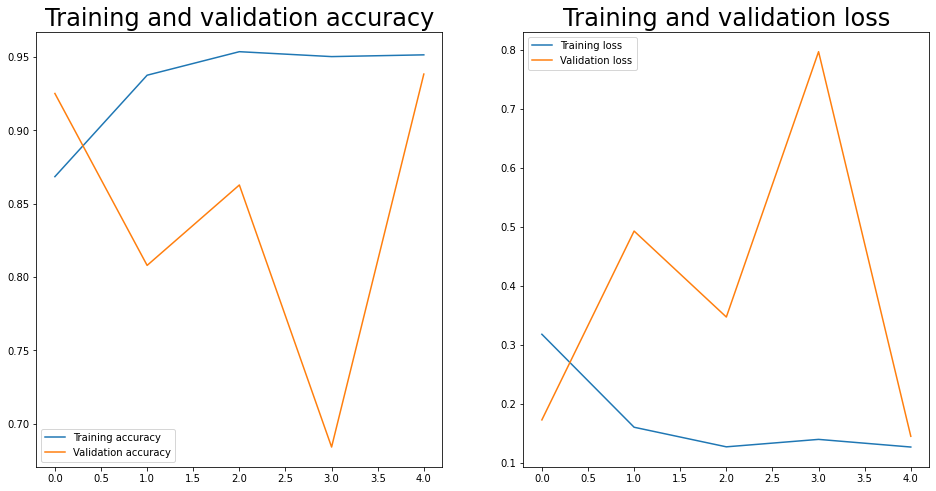

In [36]:
# Grab model results from history dict for plotting
tx_acc = tx_history.history['binary_accuracy']
tx_val_acc = tx_history.history['val_binary_accuracy']
tx_loss = tx_history.history['loss']
tx_val_loss = tx_history.history['val_loss']
tx_epochs = range(len(tx_acc))

# Plot train and val accuracy for each epoch
tx_fig,tx_ax = plt.subplots(1,2,figsize=(16,8))
tx_ax[0].plot(tx_epochs, tx_acc, label='Training accuracy');
tx_ax[0].plot(tx_epochs, tx_val_acc, label='Validation accuracy');
tx_ax[0].set_title('Training and validation accuracy',fontsize=24);
tx_ax[0].legend();

# Plot train and val loss for each epoch
tx_ax[1].plot(tx_epochs, tx_loss, label='Training loss');
tx_ax[1].plot(tx_epochs, tx_val_loss, label='Validation loss');
tx_ax[1].set_title('Training and validation loss',fontsize=24);
tx_ax[1].legend();

<h1>Model Results

In [37]:
# Evaluate the model on training set
tx_train_res = tx_model.evaluate(train_ds)

131/131 [==============================] - 39s 292ms/step - loss: 0.1091 - binary_accuracy: 0.9559 - precision_1: 0.9565 - recall_1: 0.9855


In [38]:
# Evaludate the model on validation set
tx_val_res = tx_model.evaluate(val_ds)

34/34 [==============================] - 4s 101ms/step - loss: 0.1450 - binary_accuracy: 0.9385 - precision_1: 0.9972 - recall_1: 0.9195


In [39]:
# Evaluate the model on test set
tx_test_res = tx_model.evaluate(test_ds)

20/20 [==============================] - 2s 103ms/step - loss: 0.2471 - binary_accuracy: 0.9071 - precision_1: 0.8860 - recall_1: 0.9769


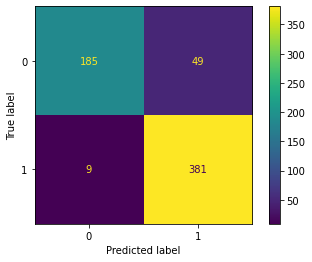

In [40]:
# Get predictions for test set and actual values
tx_test_predictions = np.round(tx_model.predict(test_ds),0)
test_actual = test_ds.labels

# Generate confusion matrix for test set
tx_c_matrix = confusion_matrix(test_actual,tx_test_predictions)
ConfusionMatrixDisplay(tx_c_matrix).plot()

<h1><a href=https://github.com/marcotcr/lime>Lime</a> Explanation of Results

In [41]:
explainer = lime_image.LimeImageExplainer()

<h1>True Positives</h1>

Xrays that contain pneumonia that the model correctly identifies as containing pneumonia.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

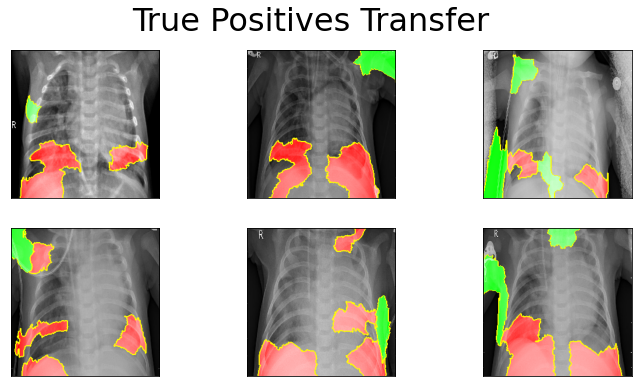

In [42]:
# Extract true positives from test set and explain with lime
tx_tp = extract_selected(tx_model,1,1)
tx_tp_expl = lime_explain(tx_model,tx_tp,"True Positives Transfer")

<h1>True Negatives</h1>

Xrays that are normal that the model correctly identifies as normal.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

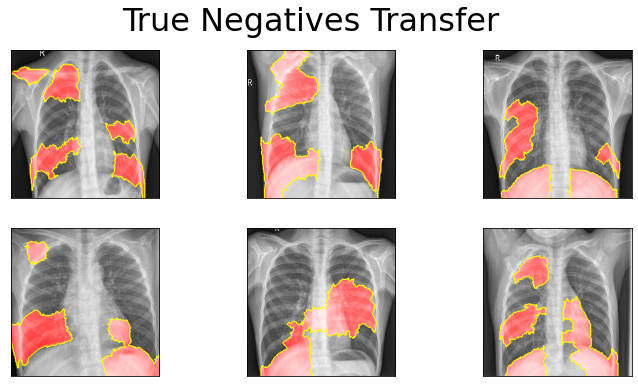

In [43]:
# Extract true negatives from test set and explain with lime
tx_tn = extract_selected(tx_model,0,0)
tx_tn_expl = lime_explain(tx_model,tx_tn,"True Negatives Transfer")

<h1>Fasle Positives</h1>

Xrays that are normal that the model incorrectly identifies as having pneumonia.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

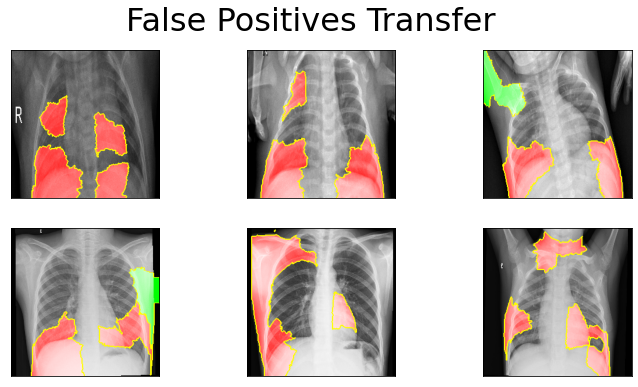

In [44]:
# Extract false positives from test set and explain with lime
tx_fp = extract_selected(tx_model,0,1)
tx_fp_expl = lime_explain(tx_model,tx_fp,"False Positives Transfer")

<h1>False Negatives</h1>

Xrays that have pneumonia that the model incorrectly identifies as normal.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

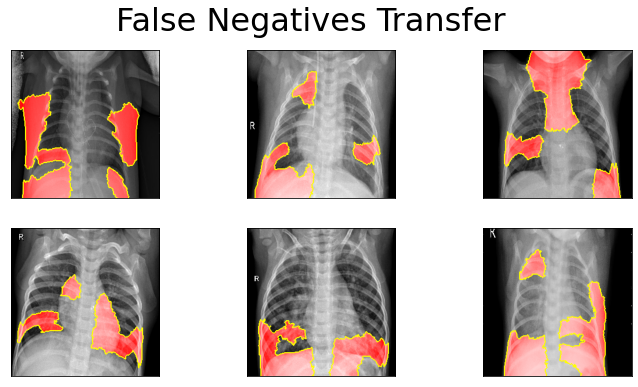

In [45]:
# Extract false negatives from test set and explain with lime
tx_fn = extract_selected(tx_model,1,0)
tx_fn_expl = lime_explain(tx_model,tx_fn,"False Negatives Transfer")

<h1>Intermediate Activations</h1>

The following attempts to show what each of the intermediate layers of the model "sees".

In [46]:
# Print overview of the model
tx_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               16777728  
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                

In [47]:
# Print overview of the model's vgg16 layers
tx_model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

The following cell returns the activation for each node in the network when a single image is passed through it.

In [48]:
# Collect outputs for the vgg16 layers
tx_layer_outputs = [layer.output for layer in tx_model.layers[0].layers]

tx_activation_model = models.Model(
    inputs = tx_model.layers[0].input,
    outputs = tx_layer_outputs
)

# Predict the first image in test dataset and save intermediate activations
tx_activations = tx_activation_model.predict(np.expand_dims(test_ds[0][0][0],axis=0))

This figure shows the activation of each node in the first convolutional layer of the network.

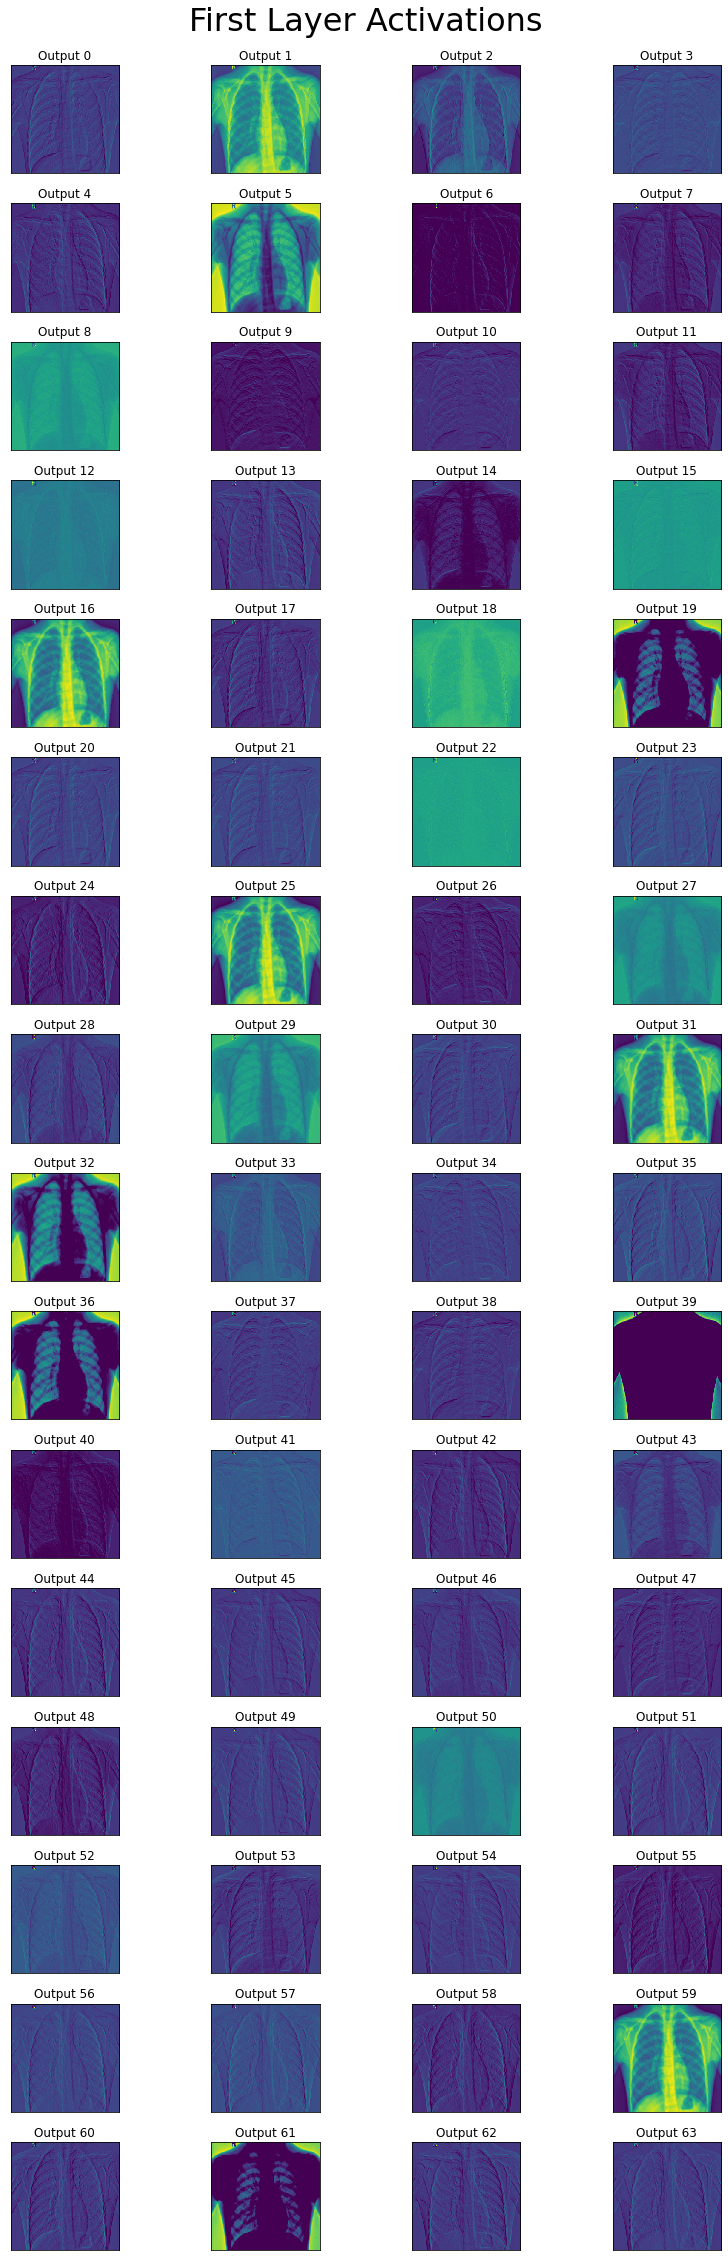

In [49]:
tx_l0_fig, tx_l0_ax = plt.subplots(16, 4, figsize=(12,32))

# Loop through each node in the first layer size 64
for idx in range(64):
    active_axis = tx_l0_ax[idx//4, idx%4]

    # EXtract and show node's activation
    first_layer_activation = tx_activations[1]
    active_axis.matshow(first_layer_activation[0 , :, :, idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    active_axis.set_title('Output ' + str(idx))
tx_l0_fig.set_facecolor('#FFFFFF')
tx_l0_fig.suptitle('First Layer Activations\n',fontsize=32);
tx_l0_fig.tight_layout()

This figure shows the activation of the first node in each convolutional and pooling layer of the network.

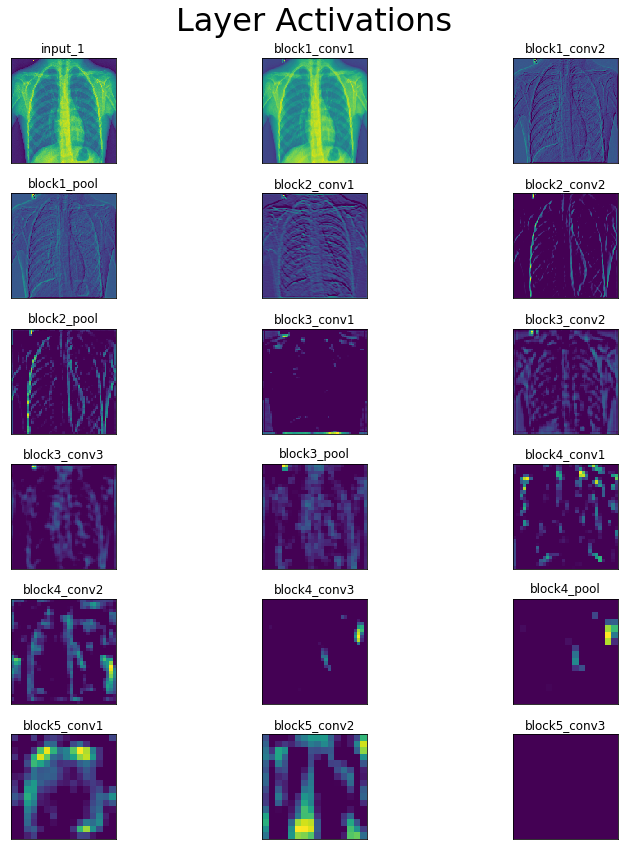

In [50]:
tx_act_fig,tx_act_ax = plt.subplots(6,3,figsize=(12,12))

# Get name for each of the vgg16 layers
tx_layer_names = []
for layer in tx_model.layers[0].layers:
    tx_layer_names.append(layer.name)

# Loop through each of the vgg16 layers
for idx in range(18):
    active_axis = tx_act_ax[idx//3][idx%3]

    # Show the activation for the first node in that layer
    cur_layer = tx_activations[idx]
    active_axis.matshow(cur_layer[0,:,:,1])
    active_axis.set_title(tx_layer_names[idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
tx_act_fig.set_facecolor('#FFFFFF')
tx_act_fig.suptitle('Layer Activations',fontsize=32);
tx_act_fig.tight_layout()